## Дано

Список рекламных блоков на месяц по заданному каналу вещания. 
Для каждого рекламного блока дана следующая информация:

•	BlockID – уникальный идентификатор блока

•	ChannelId – уникальный идентификатор канала вещания

•	ChannelName – название канала вещания

•	BlockDateTime – дата и время выхода рекламного блока в эфир

•	ProgramId – уникальный идентификатор передачи, в которой выходит рекламный блок

•	ProgramName – название передачи, в которой выходит рекламный блок

•	IsPrime – признак выхода рекламного блока в прайм-тайм

•	AvailableSeconds – количество секунд, свободных в рекламном блоке для постановки

•	BlockRate – рейтинг рекламного блока в баинговых рейтингах (рейтинг, по которой продаётся рекламный блок)

•	TargetRate – рейтинг рекламного блока в целевых рейтингах (рейтинг, который определяет качество рекламного блока для нашей целевой аудитории)

Два ролика которые надо разместить на каналах:

•	Clip1 – рекламный ролик хронометражом 30 секунд

•	Clip2 – рекламный ролик хронометражом 30 секунд

Стоимость пункта рейтинга (поле BlockRate) на канале:

•	Для рекламных блоков в прайм-тайм (IsPrime = 1) – 6 рублей

•	Для рекламных блоков не в прайм-тайм (IsPrime = 0) – 3 рубля

In [1]:
import pandas as pd
import numpy as np
import sklearn
import scipy
from scipy import optimize
import math
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import differential_evolution

%matplotlib inline

In [2]:
data = pd.read_excel('TvBreaksData_toSend.xlsx')

In [3]:
data.head(10)

,BlockID,ChannelId,ChannelName,BlockDateTime,ProgramId,ProgramName,IsPrime,AvailableSeconds,BlockRate,TargetRate
0,1696668767,1,Первый,2018-04-01 06:12:00,263640,Р/б после новостей,0,60,0.250,0.286084
1,1696668723,1,Первый,2018-04-01 06:30:00,428390,"Худ. фильм / Сериал (Х/ф ""Два билета на дневно...",0,240,0.250,0.247150
2,1696668724,1,Первый,2018-04-01 06:45:00,428390,"Худ. фильм / Сериал (Х/ф ""Два билета на дневно...",0,240,0.250,0.266853
3,1696668727,1,Первый,2018-04-01 07:15:00,428390,"Худ. фильм / Сериал (Х/ф ""Два билета на дневно...",0,230,0.250,0.376078
4,1696668830,1,Первый,2018-04-01 07:45:30,428005,Р/б до Мультфильма,0,205,0.281,0.438114
5,1696668722,1,Первый,2018-04-01 08:18:00,372302,Часовой,1,220,0.250,0.465115
6,1696668719,1,Первый,2018-04-01 08:43:10,19260,Здоровье,1,95,0.485,0.624502
7,1696668720,1,Первый,2018-04-01 09:08:36,19260,Здоровье,1,10,0.541,0.761865
8,1696668721,1,Первый,2018-04-01 09:22:48,19260,Здоровье,1,125,0.788,0.951145
9,1696668804,1,Первый,2018-04-01 09:48:10,428120,Непутевые заметки,1,55,1.209,1.340181


In [8]:
data.shape

(1793, 10)

In [9]:
type(data)

pandas.core.frame.DataFrame

In [10]:
data.dropna().shape #пропущенных значений в данных нет

(1793, 10)

## Задача

Реализовать на Python алгоритм, выбирающий рекламные блоки для размещения рекламных роликов Clip1 и Clip2 с учётом свободного места в рекламных блоках и максимизирующий сумму целевых рейтингов (поле TargetRate) выбранных блоков с учётом следующих ограничений:

•	Ролик Clip1 должен быть размещён на 100 рейтингов (сумма по колонке BlockRate), причём 58-60% размещения (58-60 рейтингов) должно быть размещено в прайм-тайм (IsPrime = 1). Допустимое отклонение размещения по рейтингам ±2%.

•	Ролик Clip2 должен быть размещён на 60 рейтингов (сумма по колонке BlockRate), причём 48-50% размещения (28.8-30 рейтингов) должно быть размещено в прайм-тайм (IsPrime = 1). Допустимое отклонение размещения по рейтингам ±2%.

•	Общая сумма размещения по двум роликам должна быть равна 750 рублям. Допустимое отклонение бюджета в меньшую сторону – 5 рублей. В большую сторону отклонение недопустимо.

•	Ролики должны быть максимально равномерно распределены по всему месяцу размещения.

In [12]:
np.unique(data.ChannelName) #только Первый канал - не значимая переменная

array(['Первый'], dtype=object)

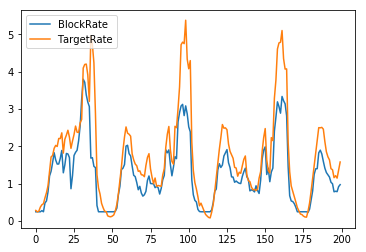

In [8]:
plt.plot(data.BlockRate[:200])
plt.plot(data.TargetRate[:200])
plt.legend()

### Будем решать задачу с использованием жадного алгоритма (серия локальных экстремумов дает глобальный экстремум)
## Максимизируем TargetRate

In [19]:
data2 = data[data.AvailableSeconds >= 30].drop(['ChannelId', 'ChannelName', 'ProgramId', 'ProgramName'], axis = 'columns') #убрали недопустимые блоки

In [20]:
data2.head(10)

,BlockID,BlockDateTime,IsPrime,AvailableSeconds,BlockRate,TargetRate
0,1696668767,2018-04-01 06:12:00,0,60,0.250,0.286084
1,1696668723,2018-04-01 06:30:00,0,240,0.250,0.247150
2,1696668724,2018-04-01 06:45:00,0,240,0.250,0.266853
3,1696668727,2018-04-01 07:15:00,0,230,0.250,0.376078
4,1696668830,2018-04-01 07:45:30,0,205,0.281,0.438114
5,1696668722,2018-04-01 08:18:00,1,220,0.250,0.465115
6,1696668719,2018-04-01 08:43:10,1,95,0.485,0.624502
8,1696668721,2018-04-01 09:22:48,1,125,0.788,0.951145
9,1696668804,2018-04-01 09:48:10,1,55,1.209,1.340181
10,1705982880,2018-04-01 10:27:45,1,130,1.336,1.718011


Функция, на вход которой подается часть блоков и необходимое количество пунктов рейтингов.

Предположительно, вначале подаем на вход праймовые блоки и набираем максимально возможное количество РУБЛЕЙ, затем подаем оффпрайм и набираем оставшуюся сумму в рублях.

При этом алгоритм должен выбирать блоки равномерно по сетке.


Функция возвращает список отобранных блоков.

# Попытка сделать самой, но не правильно)))

In [84]:
def decision(data, need_rate, need_rub = 0):
    block_selected = []
    price = 6
    data.sort_values(by=['TargetRate'], ascending=False, inplace=True)
    sum_block_rate = 0
    sum_target_rate = 0
    sum_rub = 0
    i = 0
    while sum_block_rate < need_rate:
        sum_block_rate = sum_block_rate + data.BlockRate[i]
        sum_target_rate = sum_target_rate + data.TargetRate[i] 
        i += 1
        block_selected.append(data.BlockID)
        data.AvailableSeconds[i] -= 30
    sum_rub = sum_block_rate * price
    print(sum_block_rate, sum_target_rate, sum_rub)
    return block_selected, sum_block_rate, sum_rub

# Задача об укладке рюкзака
Нельзя решать методами Динамического Программирования, т.к. вещественные веса. Решаем методом ветвей и границ


# Дальше не сделано

In [1]:
def backpack_problem(K, W, P, n): #K - предельный вес рюкзака, W - веса предметов, P - цена предметов
# Ввод:
# Ценности предметов (загруженные в массив P)
# Веса предметов (загруженные в массив W)
# Количество предметов (n)
# Грузоподъемность (K)

for j in range(K+1) do:
    m[0, j] = 0

for i from 1 to n do:
    for j from 0 to K do:
        if w[i] > j then:
            m[i, j] = m[i-1, j]
        else:
            m[i, j] = max(m[i-1, j], m[i-1, j-W[i]] + P[i])
    return Ans

IndentationError: expected an indented block (<ipython-input-1-096d0f726557>, line 8)

In [22]:
def branch_and_bound_solve(problem, objective_function, lower_bound_function):
#CombinatorProblem, ObjectiveFunction (f), BoundingFunction (g)
    ###Step 1
    #double
    problem_upper_bound = float('inf') #std::numeric_limits<double>::infinity; // = B
    #CombinatorialSolution 
    heuristic_solution = #???????????? heuristic_solve(problem); // x_h
    problem_upper_bound = objective_function(heuristic_solution) #; // B = f(x_h)
    #CombinatorialSolution 
    current_optimum = heuristic_solution;
    ###Step 2
    candidate_queue = [] #queue<CandidateSolutionTree> candidate_queue; // problem-specific queue initialization
    candidate_queue = #???????? populate_candidates(problem);
    while (candidate_queue != []) #(!candidate_queue.empty()) { 
        ###Step 3
        ##Step 3.1
        #CandidateSolutionTree 
        node = candidate_queue.pop();
        #// "node" represents N above
        if #???????????????????(node.represents_single_candidate()) { 
            ##// Step 3.2
            if #?////////////////(objective_function(node.candidate()) < problem_upper_bound) {
                current_optimum = #??????????node.candidate();
                problem_upper_bound = #????????//objective_function(current_optimum);}
            #// else, node is a single candidate which is not optimum}
        else #{ // 
            ##Step 3.3: node represents a branch of candidate solutions
            #// "child_branch" represents N_i above
            for #????/////(auto&& child_branch : node.candidate_nodes) {
                if #???/(lower_bound_function(child_branch) <= problem_upper_bound) {
                    #???????candidate_queue.enqueue(child_branch)#; // 
                    ##Step 3.3.2}
                #// otherwise, g(N_i) > B so we prune the branch; step 3.3.1}}}
    return current_optimum#;}

SyntaxError: invalid syntax (<ipython-input-22-daf0207f2b1a>, line 7)

In [31]:
data_Prime = data2.loc[data2.IsPrime == 1]
data_Prime['Cost'] = data_Prime['TargetRate']/data_Prime['BlockRate']
data_Prime.sort_values(by='Cost', ascending=False, inplace=True)
data_Prime.reset_index(inplace=True, drop=True)
data_Prime.head()

/home/puchkinda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/puchkinda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,BlockID,BlockDateTime,IsPrime,AvailableSeconds,BlockRate,TargetRate,Cost
0,1697546534,2018-04-30 08:05:30,1,215,0.323,1.648603,5.104033
1,1697545769,2018-04-30 08:38:00,1,195,0.290,1.441056,4.969160
2,1696676562,2018-04-15 00:38:50,1,140,0.769,2.273190,2.956034
3,1706002770,2018-04-01 22:53:48,1,90,1.687,4.957468,2.938630
4,1697546388,2018-04-30 09:09:45,1,35,0.473,1.387497,2.933399


In [32]:
data_Offprime = data2.loc[data2.IsPrime == 0]
data_Offprime['Cost'] = data_Offprime['TargetRate']/data_Offprime['BlockRate']
data_Offprime.sort_values(by='Cost', ascending=False, inplace=True)
data_Offprime.reset_index(inplace=True, drop=True)
data_Offprime.head()

/home/puchkinda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/puchkinda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,BlockID,BlockDateTime,IsPrime,AvailableSeconds,BlockRate,TargetRate,Cost
0,1697546772,2018-04-30 05:44:30,0,60,0.107,0.704722,6.586186
1,1697545715,2018-04-30 06:12:00,0,60,0.259,1.396077,5.390260
2,1697546557,2018-04-30 06:31:20,0,240,0.200,1.060772,5.303859
3,1696676549,2018-04-15 04:59:00,0,180,0.096,0.395217,4.116846
4,1696668838,2018-04-02 01:22:51,0,65,0.250,0.888835,3.555340


In [ ]:
boxV = np.array(data_Prime.BlockRate * 1000, dtype=int)
boxC = np.array(data_Prime.TargetRate * 1000, dtype=int)
x = len(boxV)
V = 60*1000
Xarr = np.zeros((x, x+1))

In [108]:
def A1(V, x, boxV, boxC, Xarr): 
# текущий объем, номер текущего элемента, 
# данные [1..n], результат [1..n, 0..n]
    n = len(boxV)
    if x == 0: #останов рекурсии
        k = min(V // boxV[0], 1)
        Xarr[0,n] = k*boxC[0]
        # формирование вектора при x = 1
        for j in range(1, n):
            Xarr[0, j] = 0
        Xarr[0, 0] = k
    else: # рекурсия
        # обнуление оптимального вектора
        for j in range(0, n+1):
            Xarr[x, j] = 0
        k = min(1, V // boxV[x])
        for i in range(0, k+1): #цикл поиска максимума
            Xarr = A1(V-boxV[x]*i, x-1, boxV, boxC, Xarr)
            cost = i * boxC[x] + Xarr[x-1, n]
            if cost > Xarr[x, n]: 
                #копирование вектора от x-1
                for j in range(0, n):
                    Xarr[x, j] = Xarr[x-1, j]
                Xarr[x, x] = i # количество грузов
                Xarr[x, n] = cost # оптимальная стоимость 
    
    return Xarr

%time
A1(V, x-1, boxV, boxC, Xarr)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.91 µs


KeyboardInterrupt: 

In [ ]:
block_selected = []
for i in range(len(data.Prime)):
    if Xarr.loc[-1, i] == 1:
        block_selected.append(i)

In [ ]:
sum_target_rate = 0
sum_block_rate = 0
for i in range(len(block_selected)):
    data_Prime.AvailableSeconds[i] -= 30
    sum_target_rate += data_Prime.TargetRate[i]
    sum_block_rate += data_Prime.BlockRate[i]
    
sum_rub = 6*sum_block_rate

In [85]:
block_selected, sum_block_rate, sum_rub = decision(data_Prime, 58)

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


59.623000000000005 78.43840575637107 357.73800000000006


In [86]:
decision(data_Offprime, 100 - sum_block_rate, 750 - sum_rub)

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


41.183 51.249518402549285 247.098


([724    1696685513
  334    1696676302
  521    1696683942
  158    1696668638
  593    1696685519
  395    1696683948
  218    1696676308
  588    1696685378
  37     1696668643
  676    1696685465
  219    1696676307
  643    1696685445
  38     1696668644
  707    1696685487
  394    1696683947
  592    1696685518
  482    1696683816
  624    1696685521
  652    1696685384
  578    1696685406
  424    1696683950
  245    1696676310
  579    1696685407
  764    1697545551
  723    1696685527
  657    1696685523
  520    1696683956
  22     1696668526
  205    1696676190
  383    1696683830
            ...    
  48     1705987994
  182    1696668822
  198    1705988114
  569    1696685688
  225    1696676512
  601    1696685723
  403    1696684152
  810    1697546067
  284    1696676287
  811    1697545640
  668    1696685498
  466    1696683927
  282    1696676530
  666    1696685741
  464    1696684170
  255    1696676284
  434    1696683924
  634    1696685495
  49     1705987995


In [76]:
data_Prime.head()

,index,BlockID,BlockDateTime,ProgramId,ProgramName,IsPrime,AvailableSeconds,BlockRate,TargetRate
360,1601,1696685834,2018-04-27 23:05:12,361544,Развлекательная программа,1,45,2.748,5.789471
67,352,1696668958,2018-04-06 22:47:50,701882357,Голос. Дети,1,40,3.450,5.768682
316,1279,1696685545,2018-04-22 20:33:12,428219,Развлекательная программа (в),1,130,3.403,5.462932
315,1278,1696685544,2018-04-22 20:06:24,428219,Развлекательная программа (в),1,40,3.238,5.422369
33,98,1696668687,2018-04-02 21:51:18,51117,"Сериал (пн-пт) (Сериал ""Тот, кто читает мысли""...",1,115,3.086,5.380345


In [80]:
data_Offprime = data2.loc[data2.IsPrime == 0]
data_Offprime.reset_index(inplace=True)
data_Offprime.head()

,index,BlockID,BlockDateTime,ProgramId,ProgramName,IsPrime,AvailableSeconds,BlockRate,TargetRate
0,0,1696668767,2018-04-01 06:12:00,263640,Р/б после новостей,0,60,0.250,0.286084
1,1,1696668723,2018-04-01 06:30:00,428390,"Худ. фильм / Сериал (Х/ф ""Два билета на дневно...",0,240,0.250,0.247150
2,2,1696668724,2018-04-01 06:45:00,428390,"Худ. фильм / Сериал (Х/ф ""Два билета на дневно...",0,240,0.250,0.266853
3,3,1696668727,2018-04-01 07:15:00,428390,"Худ. фильм / Сериал (Х/ф ""Два билета на дневно...",0,230,0.250,0.376078
4,4,1696668830,2018-04-01 07:45:30,428005,Р/б до Мультфильма,0,205,0.281,0.438114


In [55]:
data_Prime = data2.loc[data2.IsPrime == 1]
data_Prime.reset_index(inplace=True)
data_Prime.head()

,index,BlockID,BlockDateTime,ProgramId,ProgramName,IsPrime,AvailableSeconds,BlockRate,TargetRate
0,5,1696668722,2018-04-01 08:18:00,372302,Часовой,1,220,0.250,0.465115
1,6,1696668719,2018-04-01 08:43:10,19260,Здоровье,1,95,0.485,0.624502
2,8,1696668721,2018-04-01 09:22:48,19260,Здоровье,1,125,0.788,0.951145
3,9,1696668804,2018-04-01 09:48:10,428120,Непутевые заметки,1,55,1.209,1.340181
4,10,1705982880,2018-04-01 10:27:45,428196,"Док. фильм (Д/ф ""Н. Мордюкова. ""Прости меня за...",1,130,1.336,1.718011
